# **Text Emotion Detection**

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Loading / Preprocessing data

In [3]:
def load_preprocess_data(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
    texts, labels = [], []
    for line in lines:
        line = line.split('\n')[0]
        text, label = line.split(';')
        texts.append(text)
        labels.append(label)
    return texts, labels

train_texts, train_labels = load_preprocess_data('train.txt')
test_texts, test_labels = load_preprocess_data('test.txt')
val_texts, val_labels = load_preprocess_data('val.txt')

In [4]:
train_texts[:5], train_labels[:5]

(['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 ['sadness', 'sadness', 'anger', 'love', 'anger'])

In [5]:
## converting into pd.DataFrame
train_df = pd.DataFrame({'texts': train_texts, 'target': train_labels})
test_df = pd.DataFrame({'texts': test_texts, 'target': test_labels})

In [6]:
train_df.head()

,texts,target
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [7]:
train_df.shape

(16000, 2)

In [8]:
test_df.shape

(2000, 2)

<Axes: xlabel='target', ylabel='count'>

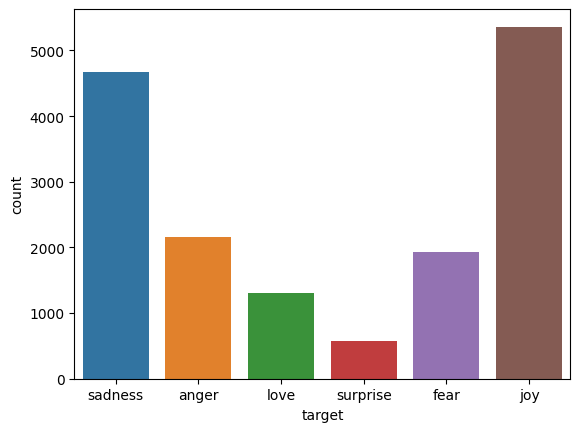

In [9]:
import seaborn as sns
sns.countplot(x='target', data=train_df)

In [10]:
from sklearn.preprocessing import LabelEncoder
lr = LabelEncoder()
train_df['target'] = lr.fit_transform(train_df['target'])
test_df['target'] = lr.transform(test_df['target'])

In [11]:
train_df.head()

,texts,target
0,i didnt feel humiliated,4
1,i can go from feeling so hopeless to so damned...,4
2,im grabbing a minute to post i feel greedy wrong,0
3,i am ever feeling nostalgic about the fireplac...,3
4,i am feeling grouchy,0


In [12]:
test_df.head()

,texts,target
0,im feeling rather rotten so im not very ambiti...,4
1,im updating my blog because i feel shitty,4
2,i never make her separate from me because i do...,4
3,i left with my bouquet of red and yellow tulip...,2
4,i was feeling a little vain when i did this one,4


In [13]:
X_train = train_df['texts'].to_numpy()
y_train = train_df['target'].to_numpy()

X_test = test_df['texts'].to_numpy()
y_test = test_df['target'].to_numpy()

In [14]:
X_train, X_train.shape

(array(['i didnt feel humiliated',
        'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
        'im grabbing a minute to post i feel greedy wrong', ...,
        'i feel strong and good overall',
        'i feel like this was such a rude comment and im glad that t',
        'i know a lot but i feel so stupid because i can not portray it'],
       dtype=object),
 (16000,))

## Setting up TextVectorization Layer

Average Tokens per Tweet is : 19 tokens
95% of our data has : 41 tokens


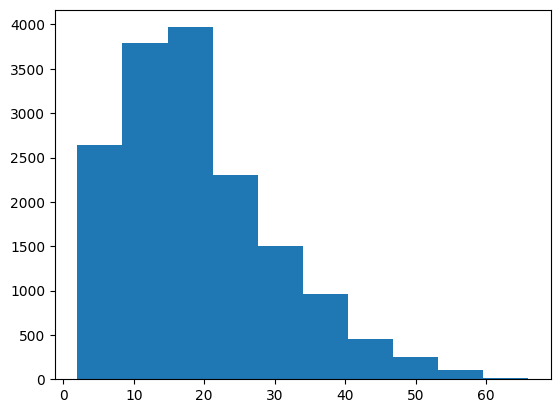

In [15]:
# find the average number of tokens per sentence
texts_length = [len(text.split()) for text in X_train]
plt.hist(texts_length)

np.percentile(texts_length, 95)
average_tokens_per_tweet = round(sum(texts_length)/X_train.shape[0])
print(f'Average Tokens per Tweet is : {average_tokens_per_tweet} tokens')
print(f'95% of our data has : {int(np.percentile(texts_length, 95))} tokens')

In [16]:
# Building Tensorflow TextVectorization Layer
from tensorflow.keras.layers import TextVectorization

max_vocab_size = 30000
max_length = 45

text_vectorizer = TextVectorization(max_tokens=max_vocab_size, # how many words in the vocabulary
                                    output_sequence_length=max_length,
                                    output_mode='int')

# Fit the text_vectorizer to train_data
text_vectorizer.adapt(X_train)

In [17]:
# visualize random setence without and with Text-Vectorization
import random
random_tweet = random.choice(X_train)
print(f'Original Tweet : \n {random_tweet}')
text_vectorized_tweet = text_vectorizer([random_tweet])
print(f'Vectorized Tweet : \n {text_vectorized_tweet}\n Shape = {text_vectorized_tweet.shape}')

Original Tweet : 
 i wonder how it feels to have angered and disappointed millions of people in one morning
Vectorized Tweet : 
 [[   2  530   53   13  123    5   21 1609    4  436 2888   10   63   12
    71  237    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]]
 Shape = (1, 45)


In [18]:
vectorized_X = text_vectorizer(X_train)
vectorized_X

<tf.Tensor: shape=(16000, 45), dtype=int64, numpy=
array([[   2,  140,    3, ...,    0,    0,    0],
       [   2,   40,  102, ...,    0,    0,    0],
       [  17, 3316,    7, ...,    0,    0,    0],
       ...,
       [   2,    3,  326, ...,    0,    0,    0],
       [   2,    3,   14, ...,    0,    0,    0],
       [   2,   47,    7, ...,    0,    0,    0]])>

## Making faster data input pipelines

In [19]:
train_labels_one_hot = tf.one_hot(y_train, depth=len(lr.classes_))
test_labels_one_hot = tf.one_hot(y_test, depth=len(lr.classes_))

In [20]:
train_labels_one_hot

<tf.Tensor: shape=(16000, 6), dtype=float32, numpy=
array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)>

In [21]:
# Turn our data into TensorFlow Datasets
train_data = tf.data.Dataset.from_tensor_slices((vectorized_X,
												train_labels_one_hot))
train_data = train_data.batch(32).prefetch(tf.data.AUTOTUNE)


# Turn our data into TensorFlow Datasets
test_data = tf.data.Dataset.from_tensor_slices((text_vectorizer(X_test),
												test_labels_one_hot))
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [22]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 45), dtype=tf.int64, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None))>

In [23]:
batchX, batchY = train_data.as_numpy_iterator().next()
batchX.shape, batchY.shape

((32, 45), (32, 6))

In [24]:
batchX, batchY

(array([[   2,  140,    3, ...,    0,    0,    0],
        [   2,   40,  102, ...,    0,    0,    0],
        [  17, 3316,    7, ...,    0,    0,    0],
        ...,
        [   2,    3,   38, ...,    0,    0,    0],
        [   2,   55, 3321, ...,    0,    0,    0],
        [   2,  190,    9, ...,    0,    0,    0]]),
 array([[0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0.],

## Model Building

In [25]:
# setting up callbacks
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

In [38]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout

In [39]:
model = Sequential()
model.add(Embedding(input_dim=len(text_vectorizer.get_vocabulary()), output_dim=128, input_length=max_length))
model.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=True)))
model.add(Bidirectional(LSTM(64, activation='tanh')))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(lr.classes_), activation='softmax'))

In [40]:
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 45, 128)           1947392   
                                                                 
 bidirectional_4 (Bidirectio  (None, 45, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 6)                 1

In [42]:
history = model.fit(train_data, epochs=20, validation_data=test_data,
                    callbacks=[create_model_checkpoint(model_name='Bi_LSTM_dense')])

Epoch 1/20
497/500 [============================>.] - ETA: 0s - loss: 1.0884 - accuracy: 0.5858

500/500 [==============================] - 71s 117ms/step - loss: 1.0855 - accuracy: 0.5871 - val_loss: 0.5111 - val_accuracy: 0.8390
Epoch 2/20
496/500 [============================>.] - ETA: 0s - loss: 0.2846 - accuracy: 0.9027

500/500 [==============================] - 37s 75ms/step - loss: 0.2842 - accuracy: 0.9028 - val_loss: 0.3136 - val_accuracy: 0.9020
Epoch 3/20
500/500 [==============================] - ETA: 0s - loss: 0.1545 - accuracy: 0.9473

500/500 [==============================] - 42s 83ms/step - loss: 0.1545 - accuracy: 0.9473 - val_loss: 0.2937 - val_accuracy: 0.9090
Epoch 4/20
499/500 [============================>.] - ETA: 0s - loss: 0.1015 - accuracy: 0.9654

500/500 [==============================] - 37s 73ms/step - loss: 0.1016 - accuracy: 0.9653 - val_loss: 0.2776 - val_accuracy: 0.9170
Epoch 5/20
500/500 [==============================] - 10s 21ms/step - loss: 0.0788 - accuracy: 0.9731 - val_loss: 0.2982 - val_accuracy: 0.9135
Epoch 6/20
500/500 [==============================] - 12s 25ms/step - loss: 0.0623 - accuracy: 0.9785 - val_loss: 0.3380 - val_accuracy: 0.9185
Epoch 7/20
500/500 [==============================] - 14s 28ms/step - loss: 0.0518 - accuracy: 0.9834 - val_loss: 0.3739 - val_accuracy: 0.9100
Epoch 8/20
500/500 [==============================] - 9s 18ms/step - loss: 0.0471 - accuracy: 0.9842 - val_loss: 0.3288 - val_accuracy: 0.9105
Epoch 9/20
500/500 [==============================] - 10s 21ms/step - loss: 0.0370 - accuracy: 0.9874 - val_loss: 0.3260 - val_accuracy: 0.9145
Epoch 10/20
500/500 [==============================] - 9s 17ms/step - loss: 0.0331 - accuracy: 0.9885 - val_loss: 0.4099 - val_accuracy: 0.9115
Epoc

## Conv1D model

In [43]:
from keras.layers import Conv1D, MaxPooling1D, Flatten

In [44]:
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=len(text_vectorizer.get_vocabulary()), output_dim=128, input_length=max_length))
cnn_model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2, strides=2))
cnn_model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2, strides=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dense(len(lr.classes_), activation='softmax'))

cnn_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [45]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 45, 128)           1947392   
                                                                 
 conv1d (Conv1D)             (None, 41, 64)            41024     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 20, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 64)            20544     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 8, 64)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 512)              

In [46]:
history_cnn = cnn_model.fit(train_data, epochs=20, validation_data=test_data,
                            callbacks=[create_model_checkpoint(model_name='CNNmodel')])

Epoch 1/20
493/500 [============================>.] - ETA: 0s - loss: 1.1215 - accuracy: 0.5474

500/500 [==============================] - 29s 44ms/step - loss: 1.1154 - accuracy: 0.5502 - val_loss: 0.5315 - val_accuracy: 0.8115
Epoch 2/20
495/500 [============================>.] - ETA: 0s - loss: 0.3229 - accuracy: 0.8849

500/500 [==============================] - 4s 8ms/step - loss: 0.3223 - accuracy: 0.8852 - val_loss: 0.3186 - val_accuracy: 0.8915
Epoch 3/20
500/500 [==============================] - 3s 7ms/step - loss: 0.1416 - accuracy: 0.9508 - val_loss: 0.3266 - val_accuracy: 0.8995
Epoch 4/20
500/500 [==============================] - 3s 6ms/step - loss: 0.0807 - accuracy: 0.9716 - val_loss: 0.3732 - val_accuracy: 0.8980
Epoch 5/20
500/500 [==============================] - 3s 6ms/step - loss: 0.0558 - accuracy: 0.9801 - val_loss: 0.4591 - val_accuracy: 0.8885
Epoch 6/20
500/500 [==============================] - 3s 6ms/step - loss: 0.0463 - accuracy: 0.9851 - val_loss: 0.4901 - val_accuracy: 0.8875
Epoch 7/20
500/500 [==============================] - 4s 7ms/step - loss: 0.0419 - accuracy: 0.9856 - val_loss: 0.4390 - val_accuracy: 0.8995
Epoch 8/20
500/500 [==============================] - 5s 10ms/step - loss: 0.0332 - accuracy: 0.9882 - val_loss: 0.4258 - val_accuracy: 0.9005
Epoch 9/20
500/5

## Model Evaluation and Predictions

In [47]:
model.evaluate(test_data)

63/63 [==============================] - 1s 8ms/step - loss: 0.4113 - accuracy: 0.9220


[0.41134729981422424, 0.921999990940094]

In [48]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [49]:
y_preds = tf.argmax(model.predict(test_data), axis=1)
y_preds

63/63 [==============================] - 2s 8ms/step


<tf.Tensor: shape=(2000,), dtype=int64, numpy=array([4, 4, 4, ..., 2, 2, 1])>

In [50]:
calculate_results(test_df['target'].to_numpy(), y_preds)

{'accuracy': 92.2,
 'precision': 0.922588537715457,
 'recall': 0.922,
 'f1': 0.9208108905173319}

<Axes: >

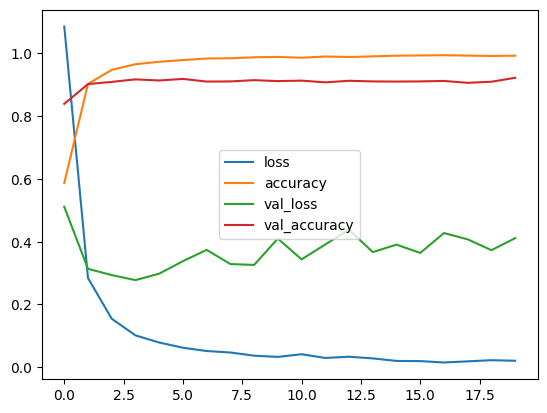

In [51]:
pd.DataFrame(history.history).plot()

In [52]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_df['target'].to_numpy(), y_preds)

array([[252,  11,   5,   0,   7,   0],
       [  2, 215,   0,   0,   5,   2],
       [  0,   8, 663,  20,   1,   3],
       [  1,   0,  36, 118,   3,   1],
       [ 13,   9,   4,   0, 554,   1],
       [  0,  17,   3,   0,   4,  42]])

In [53]:
cnn_model.evaluate(test_data)

63/63 [==============================] - 0s 4ms/step - loss: 0.7359 - accuracy: 0.8850


[0.7359461784362793, 0.8849999904632568]

In [55]:
cnn_model = tf.keras.models.load_model('/content/model_experiments/CNNmodel')
cnn_model.evaluate(test_data)

63/63 [==============================] - 1s 6ms/step - loss: 0.3186 - accuracy: 0.8915


[0.31863799691200256, 0.8914999961853027]

In [56]:
cnn_y_preds = tf.argmax(cnn_model.predict(test_data), axis=1)
cnn_y_preds

63/63 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(2000,), dtype=int64, numpy=array([4, 4, 4, ..., 2, 4, 1])>

In [57]:
calculate_results(test_df['target'].to_numpy(), cnn_y_preds)

{'accuracy': 89.14999999999999,
 'precision': 0.8894849854642066,
 'recall': 0.8915,
 'f1': 0.8867861510689202}

<Axes: >

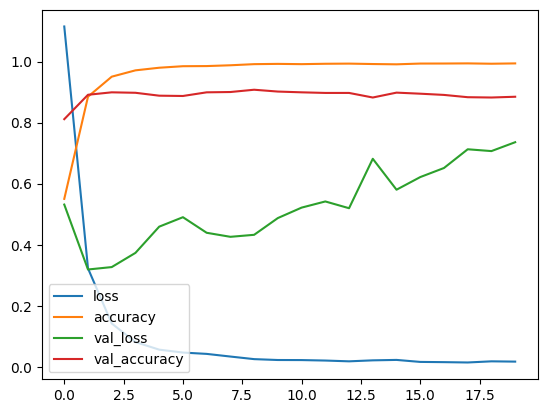

In [58]:
pd.DataFrame(history_cnn.history).plot()

In [59]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_df['target'].to_numpy(), y_preds)

array([[252,  11,   5,   0,   7,   0],
       [  2, 215,   0,   0,   5,   2],
       [  0,   8, 663,  20,   1,   3],
       [  1,   0,  36, 118,   3,   1],
       [ 13,   9,   4,   0, 554,   1],
       [  0,  17,   3,   0,   4,  42]])

## Making Custom Predictions with best model

In [69]:
lr.classes_

array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
      dtype=object)

In [67]:
class_names = lr.classes_
def predict(text):
  print(f'Original Sentence : \n {text}')
  input_tensor = text_vectorizer([text])
  y_prob = model.predict(input_tensor)
  y_pred = tf.argmax(y_prob, axis=1)
  print(f'Model Prediction : {class_names[int(y_pred)]}')
  print(f'Probability : {tf.reduce_max(y_prob)*100:.2f}%')
  print(f'Probs (all classes) : {y_prob}')

In [68]:
predict('I am very Happy, because I have successfully passed the TensorFlow Developer Certificate Exam')

Original Sentence : 
 I am very Happy, because I have successfully passed the TensorFlow Developer Certificate Exam
1/1 [==============================] - 4s 4s/step
Model Prediction : joy
Probability : 99.02%
Probs (all classes) : [[6.6772080e-03 7.8300014e-04 9.9024439e-01 1.4678094e-03 7.8064913e-04
  4.7029716e-05]]


In [73]:
predict('I fear the darkness that had lied before me')

Original Sentence : 
 I fear the darkness that had lied before me
1/1 [==============================] - 0s 65ms/step
Model Prediction : fear
Probability : 65.06%
Probs (all classes) : [[0.01731758 0.6506007  0.09549109 0.00985831 0.02982409 0.19690819]]


In [74]:
predict('I am pretty disappointed in Ayansh my brother, because he broke the T.V')

Original Sentence : 
 I am pretty disappointed in Ayansh my brother, because he broke the T.V
1/1 [==============================] - 0s 78ms/step
Model Prediction : sadness
Probability : 99.99%
Probs (all classes) : [[2.7831938e-05 5.9012942e-05 1.8014864e-05 3.3493839e-06 9.9989045e-01
  1.2724751e-06]]


In [75]:
predict('I was surprised and shocked, to see my parents bringing a 32 inch Monitor and a custom build PC and gifted me for my birthday')

Original Sentence : 
 I was surprised and shocked, to see my parents bringing a 32 inch Monitor and a custom build PC and gifted me for my birthday
1/1 [==============================] - 0s 36ms/step
Model Prediction : surprise
Probability : 98.03%
Probs (all classes) : [[5.3302927e-07 1.5948844e-03 1.6275497e-02 1.7415049e-03 1.0769408e-04
  9.8027980e-01]]


In [78]:
predict('I was very angry at my brother for he had almost broken my Keyboard')

Original Sentence : 
 I was very angry at my brother for he had almost broken my Keyboard
1/1 [==============================] - 0s 45ms/step
Model Prediction : anger
Probability : 99.98%
Probs (all classes) : [[9.9977475e-01 1.1939997e-04 6.3974527e-05 1.7808374e-05 2.3955401e-05
  1.4174317e-07]]


## Saving the Model

In [79]:
model.save('Text-Emotion_detection_BiLSTM_model.h5')